In [1]:
import pandas as pd
#import ray.dataframe as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *

import lightgbm as lgb
import os
import gc
import pickle

In [2]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        'hourofday'     : 'uint8',
        'dayofweek'     : 'uint8',
        'ip_device_os'     : 'uint32',
        'ip_device_os_app'     : 'uint32',
        'ip_device_os_app_channel' : 'uint32',
        
        }

In [ ]:
roc_auc_score

In [7]:
train = pd.read_csv("../input/train_base.csv", dtype=dtypes, skiprows=range(1,120*10**6), nrows=60* 10**6)
train.head()

,ip,app,device,os,channel,is_attributed,click_time,dayofweek,hourofday,ip_device_os,ip_device_os_app,ip_device_os_app_channel
0,53454,18,1,13,107,0,2017-11-08 15:19:33,2,15,2030562,15281242,60903495
1,95766,12,1,19,265,0,2017-11-08 15:19:33,2,15,2089086,6664161,43218990
2,44744,15,1,18,245,0,2017-11-08 15:19:33,2,15,2023985,14422182,52911397
3,29748,18,1,47,107,0,2017-11-08 15:19:33,2,15,2384319,19019190,6434270
4,71017,15,1,35,245,0,2017-11-08 15:19:33,2,15,1464977,42829,53949927


In [8]:
train.tail()

,ip,app,device,os,channel,is_attributed,click_time,dayofweek,hourofday,ip_device_os,ip_device_os_app,ip_device_os_app_channel
59999995,125312,26,1,13,121,0,2017-11-09 14:26:24,3,14,2583871,24797219,59502925
59999996,89336,9,1,13,466,0,2017-11-09 14:26:24,3,14,1276448,3639369,13177350
59999997,25039,14,1,12,349,0,2017-11-09 14:26:24,3,14,2034119,19891182,8710131
59999998,18914,14,1,35,379,0,2017-11-09 14:26:24,3,14,3370791,17324726,10320455
59999999,1895,9,1,13,215,0,2017-11-09 14:26:24,3,14,1988771,6281302,44334566


In [4]:
test = pd.read_csv("../input/test_base.csv", dtype=dtypes)
test.head()

,ip,app,device,os,channel,click_time,dayofweek,hourofday,ip_device_os,ip_device_os_app,ip_device_os_app_channel
0,5744,9,1,3,107,2017-11-10 04:00:00,4,4,298396,12014983,47945368
1,119901,9,1,3,466,2017-11-10 04:00:00,4,4,3029051,19081244,16240070
2,72287,21,1,19,128,2017-11-10 04:00:00,4,4,923739,374617,3390926
3,78477,15,1,13,111,2017-11-10 04:00:00,4,4,3569804,13383297,7284632
4,123080,12,1,13,328,2017-11-10 04:00:00,4,4,3177742,264473,40088629


In [5]:
test['hourofday'].value_counts()

4     3344125
14    3261257
13    3212566
10    3127993
9     2984808
5     2858427
15        499
11        413
6         381
Name: hourofday, dtype: int64

In [9]:
def plot_feature(df, col):
    sns.distplot(df.loc[df.is_attributed == 0, col])
    sns.distplot(df.loc[df.is_attributed == 1, col])
    plt.show()

In [10]:
def time_details(df):
    df['epoch_time'] = ((pd.to_datetime(df['click_time']) - pd.to_datetime("2017-11-06 14:00:00"))).astype(np.int64)//10**9
    df['seconds'] = (df['epoch_time'] % 60).astype(np.uint8)
    df['epoch_minute'] = (df['epoch_time'] // 60).astype(np.uint32)
    df['minutes'] = (df['epoch_minute'] % 60).astype(np.uint8)
    
    #del df['click_time']
    return df

In [11]:
train = time_details(train)

In [12]:
train['hourofday'].value_counts()

4     4032691
5     3671741
6     3570940
13    3457523
12    3363917
3     3351149
11    3347741
0     3318301
10    3304199
7     3186240
1     3082862
2     3068887
9     2986204
8     2804701
16    2455567
23    2366694
15    2070802
14    1565950
17    1387383
22    1260525
18     794088
19     554053
21     550518
20     447324
Name: hourofday, dtype: int64

In [15]:
tr, val = train_test_split(train, test_size=0.2, random_state=786)
print(tr.shape, val.shape)

(48000000, 16) (12000000, 16)


In [16]:
tr.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_time',
       'dayofweek', 'hourofday', 'ip_device_os', 'ip_device_os_app',
       'ip_device_os_app_channel', 'epoch_time', 'seconds', 'epoch_minute',
       'minutes'],
      dtype='object')

In [17]:
feats = ['ip', 'app', 'device', 'os', 'channel', 'hourofday']

In [18]:
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, 
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats], tr['is_attributed'], eval_set=[(val[feats], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.915577
[20]	valid_0's auc: 0.916071
[30]	valid_0's auc: 0.940306
[40]	valid_0's auc: 0.947476
[50]	valid_0's auc: 0.951632
[60]	valid_0's auc: 0.954337
[70]	valid_0's auc: 0.956627
[80]	valid_0's auc: 0.95797
[90]	valid_0's auc: 0.958662
[100]	valid_0's auc: 0.959445
[110]	valid_0's auc: 0.959981
[120]	valid_0's auc: 0.960567
[130]	valid_0's auc: 0.960894
[140]	valid_0's auc: 0.961219
[150]	valid_0's auc: 0.961714
[160]	valid_0's auc: 0.961992
[170]	valid_0's auc: 0.962146
[180]	valid_0's auc: 0.962403
[190]	valid_0's auc: 0.962614
[200]	valid_0's auc: 0.962894
[210]	valid_0's auc: 0.963035
[220]	valid_0's auc: 0.963388
[230]	valid_0's auc: 0.963607
[240]	valid_0's auc: 0.963776
[250]	valid_0's auc: 0.963883
[260]	valid_0's auc: 0.964011
[270]	valid_0's auc: 0.964127
[280]	valid_0's auc: 0.964261
[290]	valid_0's auc: 0.964359
[300]	valid_0's auc: 0.964475
Did not meet early stopping. Best iteration is:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [13]:
scores = []
for f in ['minutes', 'seconds', 'ip_device_os', 'ip_device_os_app',
       'ip_device_os_app_channel']:
    feats2 = feats + [f]
    
    model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                               scale_pos_weight=9, 
                           num_leaves=15, n_jobs=16)
    model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)
    
    scores.append(roc_auc_score(val['is_attributed'], model.predict_proba(val[feats2])[:,1]))

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.931993
[20]	valid_0's auc: 0.931407
[30]	valid_0's auc: 0.938612
[40]	valid_0's auc: 0.949905
[50]	valid_0's auc: 0.953076
[60]	valid_0's auc: 0.954153
[70]	valid_0's auc: 0.955884
[80]	valid_0's auc: 0.957811
[90]	valid_0's auc: 0.959064
[100]	valid_0's auc: 0.959725
[110]	valid_0's auc: 0.960616
[120]	valid_0's auc: 0.961274
[130]	valid_0's auc: 0.961624
[140]	valid_0's auc: 0.961944
[150]	valid_0's auc: 0.962338
[160]	valid_0's auc: 0.962868
[170]	valid_0's auc: 0.963145
[180]	valid_0's auc: 0.963315
[190]	valid_0's auc: 0.963429
[200]	valid_0's auc: 0.963576
[210]	valid_0's auc: 0.963776
[220]	valid_0's auc: 0.963858
[230]	valid_0's auc: 0.964032
[240]	valid_0's auc: 0.964146
[250]	valid_0's auc: 0.964216
[260]	valid_0's auc: 0.964412
[270]	valid_0's auc: 0.964514
[280]	valid_0's auc: 0.964602
[290]	valid_0's auc: 0.964705
[300]	valid_0's auc: 0.964766
Did not meet early stopping. Best iteration is

KeyboardInterrupt: 

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    A utlity class to help encode categorical variables using different methods.
    
    Inputs:
    cols: (List or str) Can be either a string or list of strings with column names
    targetcol: (str) Target column to encode column/group of columns with
    thresh: (int) Minimum count of grouping to encode (Acts as smoothing). Currently not implemented TODO
    func: (str or callable) Function to be applied on column/ group of columns to encode. 
          If str is provided, it should be a attribute of pandas Series
    cname: (str) Column name for new string
    func_kwargs: (dict) Additional arguments to be passed to function 
    add_to_orig: (bool) Whether to return dataframe with added feature or just the feature as series
    
    Output:
    pandas DataFrame/Series
    
    """
    def __init__(self, cols=None, targetcol=None, cname=None, thresh=0, func=np.mean,  add_to_orig=False,                              func_kwargs={}):
        self.cols = cols #Can be either a string or list of strings with column names
        self.targetcol = targetcol #Target column to encode column/group of columns with
        self.thresh = thresh  #Minimum count of grouping to encode (Acts as smoothing)
        self.func = func #Function to be applied on column/ group of columns to encode 
        self.add_to_orig = add_to_orig #Whether return a dataframe with added feature or just a series of feature
        self.cname = cname #Column to new feature generated
        self.func_kwargs = func_kwargs  #Additional key word arguments to be applied to func
    
    #@numba.jit        
    def fit(self, X, y=None):
            
        if isinstance(self.func, str):
            if hasattr(pd.Series, self.func):
                #print("here")
                vals = getattr(X.groupby(self.cols)[self.targetcol], self.func)
                self.dictmap = vals(**self.func_kwargs)
                
        else:
            self.dictmap = X.groupby(self.cols)[self.targetcol].apply(lambda x: self.func(x, **self.func_kwargs))
            
        if self.cname:
            self.dictmap.name = self.cname
        else:
            cname = ''
            cname = [cname + '_' +str(col) for col in self.cols]
            self.cname = '_'.join(cname) + "_" + str(self.func)
            self.dictmap.name = self.cname
            
        #print(self.cname)
        self.dictmap = self.dictmap
        return self
    
    #@numba.jit
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_transformed = X[self.cols]
            
            X_transformed = X_transformed.join(self.dictmap, on=self.cols, how='left')[self.cname]

            if self.add_to_orig:
                return pd.concat([X, X_transformed], axis=1, copy=False)
            else:
                return X_transformed.values

        else:
            raise TypeError("Input should be a pandas DataFrame")

In [21]:
%%time
app_mean = TargetEncoder(cols=['app'],  targetcol='is_attributed', func='mean')
tr['app_mean'] = app_mean.fit_transform(tr[['app', 'is_attributed']])
val['app_mean'] = app_mean.transform(val[['app', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


CPU times: user 5.75 s, sys: 5.24 s, total: 11 s
Wall time: 11 s


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
def load_if_saved(feature_generator):
    def wrapper(*args, **kwargs):
        tr_filename = kwargs.get('tr_filename', None)
        val_filename = kwargs.get('val_filename', None)
        rewrite = kwargs.get('rewrite', False) 
        if ((os.path.exists(tr_filename)) and (os.path.exists(val_filename)) and not(rewrite)):
            with open(tr_filename, "rb") as f:
                tr_data = pickle.load(f)
            with open(val_filename, "rb") as f:
                val_data = pickle.load(f)
        else:
            tr_data, val_data = feature_generator(*args, **kwargs)
            with open(tr_filename, "wb") as f:
                pickle.dump(tr_data, f)
            with open(val_filename, "wb") as f:
                pickle.dump(val_data, f)
        return tr_data, val_data
    return wrapper
    

In [51]:
@load_if_saved
def get_mean_feature(tr, val, cols, target, tr_filename="../output/tr_tmp.pkl",  
                     val_filename="../output/val_tmp.pkl", cv=5, thresh=2, seed=786, rewrite=False):
    all_cols = cols + [target]
    
    mean_enc = TargetEncoder(cols=cols,  targetcol=target, func='mean')
    cvlist = KFold(n_splits=cv, shuffle=True, random_state=seed).split(tr[target])
    
    tr_data = cross_val_predict(mean_enc, tr[all_cols], tr[target], cv=cvlist, method='transform', verbose=1)
    val_data = mean_enc.fit(tr[all_cols]).transform(val[all_cols])
    
    return tr_data, val_data

In [52]:
%%time
tr_data, val_data = get_mean_feature(tr, val, ['app'], 'is_attributed', 
                                     tr_filename="../output/tr_app_cv5mean_786.pkl", 
                                     val_filename="../output/val_app_cv5mean_786.pkl",
                                     cv=5, seed=786, rewrite=False)
tr['app_mean'] = tr_data
val['app_mean'] = val_data

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


CPU times: user 769 ms, sys: 1.19 s, total: 1.96 s
Wall time: 1.96 s


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [30]:
feats2 = feats + ['app_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, 
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)


Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.949065
[20]	valid_0's auc: 0.950168
[30]	valid_0's auc: 0.953301
[40]	valid_0's auc: 0.95579
[50]	valid_0's auc: 0.957161
[60]	valid_0's auc: 0.958794
[70]	valid_0's auc: 0.960189
[80]	valid_0's auc: 0.961454
[90]	valid_0's auc: 0.962151
[100]	valid_0's auc: 0.962541
[110]	valid_0's auc: 0.96284
[120]	valid_0's auc: 0.963286
[130]	valid_0's auc: 0.963555
[140]	valid_0's auc: 0.963671
[150]	valid_0's auc: 0.963946
[160]	valid_0's auc: 0.964093
[170]	valid_0's auc: 0.964288
[180]	valid_0's auc: 0.964451
[190]	valid_0's auc: 0.964517
[200]	valid_0's auc: 0.964665
[210]	valid_0's auc: 0.964851
[220]	valid_0's auc: 0.964959
[230]	valid_0's auc: 0.965108
[240]	valid_0's auc: 0.965251
[250]	valid_0's auc: 0.96536
[260]	valid_0's auc: 0.965429
[270]	valid_0's auc: 0.965466
[280]	valid_0's auc: 0.965508
[290]	valid_0's auc: 0.965581
[300]	valid_0's auc: 0.965613
Did not meet early stopping. Best iteration is:
[

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [18]:
#Add channel feature
channel_mean = TargetEncoder(cols=['channel'],  targetcol='is_attributed', func='mean')
tr['channel_mean'] = channel_mean.fit_transform(tr[['channel', 'is_attributed']])
val['channel_mean'] = channel_mean.transform(val[['channel', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [19]:
feats2 = feats + ['app_mean', 'channel_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.955577
[20]	valid_0's auc: 0.956665
[30]	valid_0's auc: 0.957635
[40]	valid_0's auc: 0.958415
[50]	valid_0's auc: 0.960522
[60]	valid_0's auc: 0.961381
[70]	valid_0's auc: 0.962739
[80]	valid_0's auc: 0.96361
[90]	valid_0's auc: 0.964205
[100]	valid_0's auc: 0.964661
[110]	valid_0's auc: 0.965002
[120]	valid_0's auc: 0.965159
[130]	valid_0's auc: 0.965378
[140]	valid_0's auc: 0.965581
[150]	valid_0's auc: 0.965773
[160]	valid_0's auc: 0.965876
[170]	valid_0's auc: 0.965897
[180]	valid_0's auc: 0.965912
[190]	valid_0's auc: 0.965955
[200]	valid_0's auc: 0.966025
[210]	valid_0's auc: 0.96609
[220]	valid_0's auc: 0.966162
[230]	valid_0's auc: 0.966275
[240]	valid_0's auc: 0.966366
[250]	valid_0's auc: 0.966492
[260]	valid_0's auc: 0.966523
[270]	valid_0's auc: 0.966575
[280]	valid_0's auc: 0.966628
[290]	valid_0's auc: 0.966679
[300]	valid_0's auc: 0.966706
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [20]:
#Add channel feature
ip_count = TargetEncoder(cols=['ip'],  targetcol='is_attributed', func='count')
tr['ip_count'] = ip_count.fit_transform(tr[['ip', 'is_attributed']])
val['ip_count'] = ip_count.transform(val[['ip', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [21]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.955428
[20]	valid_0's auc: 0.959576
[30]	valid_0's auc: 0.960437
[40]	valid_0's auc: 0.963847
[50]	valid_0's auc: 0.965083
[60]	valid_0's auc: 0.966075
[70]	valid_0's auc: 0.966983
[80]	valid_0's auc: 0.967657
[90]	valid_0's auc: 0.968217
[100]	valid_0's auc: 0.968553
[110]	valid_0's auc: 0.968945
[120]	valid_0's auc: 0.969108
[130]	valid_0's auc: 0.969311
[140]	valid_0's auc: 0.969573
[150]	valid_0's auc: 0.969754
[160]	valid_0's auc: 0.969839
[170]	valid_0's auc: 0.969896
[180]	valid_0's auc: 0.970012
[190]	valid_0's auc: 0.970096
[200]	valid_0's auc: 0.970205
[210]	valid_0's auc: 0.970317
[220]	valid_0's auc: 0.970392
[230]	valid_0's auc: 0.970413
[240]	valid_0's auc: 0.970437
[250]	valid_0's auc: 0.970459
[260]	valid_0's auc: 0.970475
[270]	valid_0's auc: 0.970517
[280]	valid_0's auc: 0.970547
[290]	valid_0's auc: 0.970576
[300]	valid_0's auc: 0.970623
Did not meet early stopping. Best iteration is

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [22]:
app_count = TargetEncoder(cols=['app'],  targetcol='is_attributed', func='count')
tr['app_count'] = app_count.fit_transform(tr[['app', 'is_attributed']])
val['app_count'] = app_count.transform(val[['app', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954721
[20]	valid_0's auc: 0.955847
[30]	valid_0's auc: 0.96201
[40]	valid_0's auc: 0.963195
[50]	valid_0's auc: 0.9647
[60]	valid_0's auc: 0.965887
[70]	valid_0's auc: 0.9669
[80]	valid_0's auc: 0.967644
[90]	valid_0's auc: 0.96812
[100]	valid_0's auc: 0.968461
[110]	valid_0's auc: 0.968759
[120]	valid_0's auc: 0.969035
[130]	valid_0's auc: 0.969211
[140]	valid_0's auc: 0.969385
[150]	valid_0's auc: 0.969582
[160]	valid_0's auc: 0.96972
[170]	valid_0's auc: 0.969783
[180]	valid_0's auc: 0.96984
[190]	valid_0's auc: 0.969908
[200]	valid_0's auc: 0.970018
[210]	valid_0's auc: 0.97012
[220]	valid_0's auc: 0.970184
[230]	valid_0's auc: 0.970231
[240]	valid_0's auc: 0.970293
[250]	valid_0's auc: 0.970342
[260]	valid_0's auc: 0.970333
[270]	valid_0's auc: 0.970383
[280]	valid_0's auc: 0.970451
[290]	valid_0's auc: 0.970509
[300]	valid_0's auc: 0.970525
Did not meet early stopping. Best iteration is:
[300]	v

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [24]:
#High Pulse feature
ip_dayhourmin_count = TargetEncoder(cols=['ip', 'dayofweek', 'hourofday', 'epoch_minute'],  targetcol='is_attributed', func='count')
tr['ip_dayhourmin_count'] = ip_dayhourmin_count.fit_transform(tr[['ip', 'dayofweek', 'hourofday', 'epoch_minute', 'is_attributed']])
val['ip_dayhourmin_count'] = ip_dayhourmin_count.transform(val[['ip', 'dayofweek', 'hourofday', 'epoch_minute', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [25]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_dayhourmin_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.959194
[20]	valid_0's auc: 0.958748
[30]	valid_0's auc: 0.961632
[40]	valid_0's auc: 0.96276
[50]	valid_0's auc: 0.964504
[60]	valid_0's auc: 0.965616
[70]	valid_0's auc: 0.966871
[80]	valid_0's auc: 0.967684
[90]	valid_0's auc: 0.968239
[100]	valid_0's auc: 0.968667
[110]	valid_0's auc: 0.969039
[120]	valid_0's auc: 0.96924
[130]	valid_0's auc: 0.969443
[140]	valid_0's auc: 0.96964
[150]	valid_0's auc: 0.969745
[160]	valid_0's auc: 0.969905
[170]	valid_0's auc: 0.970002
[180]	valid_0's auc: 0.970063
[190]	valid_0's auc: 0.970194
[200]	valid_0's auc: 0.970273
[210]	valid_0's auc: 0.970379
[220]	valid_0's auc: 0.970447
[230]	valid_0's auc: 0.970494
[240]	valid_0's auc: 0.970548
[250]	valid_0's auc: 0.970601
[260]	valid_0's auc: 0.970644
[270]	valid_0's auc: 0.97068
[280]	valid_0's auc: 0.970744
[290]	valid_0's auc: 0.970789
[300]	valid_0's auc: 0.970815
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [26]:
#Ip device os clicks
ip_device_os_count = TargetEncoder(cols=['ip', 'device', 'os'],  targetcol='is_attributed', func='count')
tr['ip_device_os_count'] = ip_device_os_count.fit_transform(tr[['ip', 'device', 'os', 'is_attributed']])
val['ip_device_os_count'] = ip_device_os_count.transform(val[['ip', 'device', 'os', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.958332
[20]	valid_0's auc: 0.958522
[30]	valid_0's auc: 0.961837
[40]	valid_0's auc: 0.963039
[50]	valid_0's auc: 0.964743
[60]	valid_0's auc: 0.965988
[70]	valid_0's auc: 0.9671
[80]	valid_0's auc: 0.967893
[90]	valid_0's auc: 0.96848
[100]	valid_0's auc: 0.968939
[110]	valid_0's auc: 0.969337
[120]	valid_0's auc: 0.969633
[130]	valid_0's auc: 0.969942
[140]	valid_0's auc: 0.970285
[150]	valid_0's auc: 0.970502
[160]	valid_0's auc: 0.970644
[170]	valid_0's auc: 0.970754
[180]	valid_0's auc: 0.970878
[190]	valid_0's auc: 0.971021
[200]	valid_0's auc: 0.971084
[210]	valid_0's auc: 0.971258
[220]	valid_0's auc: 0.971363
[230]	valid_0's auc: 0.97147
[240]	valid_0's auc: 0.971519
[250]	valid_0's auc: 0.971544
[260]	valid_0's auc: 0.971683
[270]	valid_0's auc: 0.971722
[280]	valid_0's auc: 0.971787
[290]	valid_0's auc: 0.97183
[300]	valid_0's auc: 0.971864
Did not meet early stopping. Best iteration is:
[29

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [28]:
#Mid Pulse feature
ip_dayhour_count = TargetEncoder(cols=['ip', 'dayofweek', 'hourofday'],  targetcol='is_attributed', func='count')
tr['ip_dayhour_count'] = ip_dayhour_count.fit_transform(tr[['ip', 'dayofweek', 'hourofday', 'is_attributed']])
val['ip_dayhour_count'] = ip_dayhour_count.transform(val[['ip', 'dayofweek', 'hourofday', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [29]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'ip_dayhour_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=1.0,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953912
[20]	valid_0's auc: 0.955843
[30]	valid_0's auc: 0.960642
[40]	valid_0's auc: 0.964303
[50]	valid_0's auc: 0.965684
[60]	valid_0's auc: 0.966523
[70]	valid_0's auc: 0.96753
[80]	valid_0's auc: 0.968361
[90]	valid_0's auc: 0.968833
[100]	valid_0's auc: 0.969212
[110]	valid_0's auc: 0.969538
[120]	valid_0's auc: 0.969694
[130]	valid_0's auc: 0.969949
[140]	valid_0's auc: 0.97023
[150]	valid_0's auc: 0.97043
[160]	valid_0's auc: 0.970697
[170]	valid_0's auc: 0.970854
[180]	valid_0's auc: 0.970987
[190]	valid_0's auc: 0.971067
[200]	valid_0's auc: 0.971156
[210]	valid_0's auc: 0.971277
[220]	valid_0's auc: 0.971392
[230]	valid_0's auc: 0.971506
[240]	valid_0's auc: 0.971597
[250]	valid_0's auc: 0.971671
[260]	valid_0's auc: 0.971742
[270]	valid_0's auc: 0.971833
[280]	valid_0's auc: 0.971884
[290]	valid_0's auc: 0.97196
[300]	valid_0's auc: 0.972049
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=1.0,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [30]:
#Mid Pulse feature
device_os_count = TargetEncoder(cols=['device', 'os'],  targetcol='is_attributed', func='count')
tr['device_os_count'] = device_os_count.fit_transform(tr[['device', 'os', 'is_attributed']])
val['device_os_count'] = device_os_count.transform(val[['device', 'os', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.9547
[20]	valid_0's auc: 0.956537
[30]	valid_0's auc: 0.960179
[40]	valid_0's auc: 0.964733
[50]	valid_0's auc: 0.965847
[60]	valid_0's auc: 0.966955
[70]	valid_0's auc: 0.967815
[80]	valid_0's auc: 0.968506
[90]	valid_0's auc: 0.969067
[100]	valid_0's auc: 0.969604
[110]	valid_0's auc: 0.969969
[120]	valid_0's auc: 0.970303
[130]	valid_0's auc: 0.970548
[140]	valid_0's auc: 0.970791
[150]	valid_0's auc: 0.970923
[160]	valid_0's auc: 0.971114
[170]	valid_0's auc: 0.971258
[180]	valid_0's auc: 0.971372
[190]	valid_0's auc: 0.971426
[200]	valid_0's auc: 0.971485
[210]	valid_0's auc: 0.971627
[220]	valid_0's auc: 0.971775
[230]	valid_0's auc: 0.971855
[240]	valid_0's auc: 0.97189
[250]	valid_0's auc: 0.971929
[260]	valid_0's auc: 0.971969
[270]	valid_0's auc: 0.972014
[280]	valid_0's auc: 0.972081
[290]	valid_0's auc: 0.972112
[300]	valid_0's auc: 0.972175
Did not meet early stopping. Best iteration is:
[

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [32]:
#Mid Pulse feature
channel_count = TargetEncoder(cols=['channel'],  targetcol='is_attributed', func='count')
tr['channel_count'] = channel_count.fit_transform(tr[['channel', 'is_attributed']])
val['channel_count'] = channel_count.transform(val[['channel', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [33]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count', 'channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953424
[20]	valid_0's auc: 0.960085
[30]	valid_0's auc: 0.961751
[40]	valid_0's auc: 0.964405
[50]	valid_0's auc: 0.966019
[60]	valid_0's auc: 0.96692
[70]	valid_0's auc: 0.967855
[80]	valid_0's auc: 0.9686
[90]	valid_0's auc: 0.969062
[100]	valid_0's auc: 0.969626
[110]	valid_0's auc: 0.970092
[120]	valid_0's auc: 0.970298
[130]	valid_0's auc: 0.970569
[140]	valid_0's auc: 0.970782
[150]	valid_0's auc: 0.97091
[160]	valid_0's auc: 0.971067
[170]	valid_0's auc: 0.971256
[180]	valid_0's auc: 0.971334
[190]	valid_0's auc: 0.971418
[200]	valid_0's auc: 0.971477
[210]	valid_0's auc: 0.971569
[220]	valid_0's auc: 0.971732
[230]	valid_0's auc: 0.971797
[240]	valid_0's auc: 0.971884
[250]	valid_0's auc: 0.971961
[260]	valid_0's auc: 0.972016
[270]	valid_0's auc: 0.972087
[280]	valid_0's auc: 0.972181
[290]	valid_0's auc: 0.972275
[300]	valid_0's auc: 0.972358
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [34]:
ip_mean = TargetEncoder(cols=['ip'],  targetcol='is_attributed', func='mean')
tr['ip_mean'] = ip_mean.fit_transform(tr[['ip', 'is_attributed']])
val['ip_mean'] = ip_mean.transform(val[['ip', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'ip_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.94879
[20]	valid_0's auc: 0.948727
[30]	valid_0's auc: 0.952211
[40]	valid_0's auc: 0.948732
[50]	valid_0's auc: 0.94184
[60]	valid_0's auc: 0.929928
[70]	valid_0's auc: 0.896709
[80]	valid_0's auc: 0.865366
[90]	valid_0's auc: 0.834993
[100]	valid_0's auc: 0.76803
[110]	valid_0's auc: 0.725232


KeyboardInterrupt: 

In [36]:
gc.collect()

372

In [37]:
device_mean = TargetEncoder(cols=['device'],  targetcol='is_attributed', func='mean')
tr['device_mean'] = device_mean.fit_transform(tr[['device', 'is_attributed']])
val['device_mean'] = device_mean.transform(val[['device', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'device_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.958718
[20]	valid_0's auc: 0.95999
[30]	valid_0's auc: 0.961778
[40]	valid_0's auc: 0.964503
[50]	valid_0's auc: 0.965684
[60]	valid_0's auc: 0.966915
[70]	valid_0's auc: 0.967934
[80]	valid_0's auc: 0.968706
[90]	valid_0's auc: 0.969083
[100]	valid_0's auc: 0.969467
[110]	valid_0's auc: 0.96981
[120]	valid_0's auc: 0.970154
[130]	valid_0's auc: 0.970339
[140]	valid_0's auc: 0.97067
[150]	valid_0's auc: 0.970767
[160]	valid_0's auc: 0.970896
[170]	valid_0's auc: 0.971002
[180]	valid_0's auc: 0.971078
[190]	valid_0's auc: 0.971156
[200]	valid_0's auc: 0.971242
[210]	valid_0's auc: 0.971331
[220]	valid_0's auc: 0.971341
[230]	valid_0's auc: 0.971376
[240]	valid_0's auc: 0.971481
[250]	valid_0's auc: 0.971587
[260]	valid_0's auc: 0.971631
[270]	valid_0's auc: 0.97174
[280]	valid_0's auc: 0.971843
[290]	valid_0's auc: 0.971873
[300]	valid_0's auc: 0.9719
Did not meet early stopping. Best iteration is:
[296

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [39]:
os_mean = TargetEncoder(cols=['os'],  targetcol='is_attributed', func='mean')
tr['os_mean'] = os_mean.fit_transform(tr[['os', 'is_attributed']])
val['os_mean'] = os_mean.transform(val[['os', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.958743
[20]	valid_0's auc: 0.959888
[30]	valid_0's auc: 0.962642
[40]	valid_0's auc: 0.964505
[50]	valid_0's auc: 0.965669
[60]	valid_0's auc: 0.967016
[70]	valid_0's auc: 0.967981
[80]	valid_0's auc: 0.968705
[90]	valid_0's auc: 0.969159
[100]	valid_0's auc: 0.969564
[110]	valid_0's auc: 0.970041
[120]	valid_0's auc: 0.970293
[130]	valid_0's auc: 0.970482
[140]	valid_0's auc: 0.970753
[150]	valid_0's auc: 0.970956
[160]	valid_0's auc: 0.971114
[170]	valid_0's auc: 0.971217
[180]	valid_0's auc: 0.971362
[190]	valid_0's auc: 0.971494
[200]	valid_0's auc: 0.971525
[210]	valid_0's auc: 0.971617
[220]	valid_0's auc: 0.971737
[230]	valid_0's auc: 0.971821
[240]	valid_0's auc: 0.971832
[250]	valid_0's auc: 0.971898
[260]	valid_0's auc: 0.971976
[270]	valid_0's auc: 0.972043
[280]	valid_0's auc: 0.972111
[290]	valid_0's auc: 0.97217
[300]	valid_0's auc: 0.972217
Did not meet early stopping. Best iteration is:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [41]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_dayhour_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954386
[20]	valid_0's auc: 0.960302
[30]	valid_0's auc: 0.962224
[40]	valid_0's auc: 0.964622
[50]	valid_0's auc: 0.966239
[60]	valid_0's auc: 0.967299
[70]	valid_0's auc: 0.96813
[80]	valid_0's auc: 0.968861
[90]	valid_0's auc: 0.969442
[100]	valid_0's auc: 0.969903
[110]	valid_0's auc: 0.970173
[120]	valid_0's auc: 0.970534
[130]	valid_0's auc: 0.970741
[140]	valid_0's auc: 0.970981
[150]	valid_0's auc: 0.971048
[160]	valid_0's auc: 0.971215
[170]	valid_0's auc: 0.97134
[180]	valid_0's auc: 0.971458
[190]	valid_0's auc: 0.971487
[200]	valid_0's auc: 0.97154
[210]	valid_0's auc: 0.971708
[220]	valid_0's auc: 0.971813
[230]	valid_0's auc: 0.971854
[240]	valid_0's auc: 0.971947
[250]	valid_0's auc: 0.971999
[260]	valid_0's auc: 0.972065
[270]	valid_0's auc: 0.972157
[280]	valid_0's auc: 0.972213
[290]	valid_0's auc: 0.97228
[300]	valid_0's auc: 0.972333
Did not meet early stopping. Best iteration is:
[2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [42]:
#unique device os on ip
ip_unq_ip_device_os = TargetEncoder(cols=['ip'],  targetcol='ip_device_os', func='nunique')
tr['ip_unq_ip_device_os'] = ip_unq_ip_device_os.fit_transform(tr[['ip', 'ip_device_os']])
val['ip_unq_ip_device_os'] = ip_unq_ip_device_os.transform(val[['ip', 'ip_device_os']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [43]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.95475
[20]	valid_0's auc: 0.960772
[30]	valid_0's auc: 0.961559
[40]	valid_0's auc: 0.964066
[50]	valid_0's auc: 0.965891
[60]	valid_0's auc: 0.967166
[70]	valid_0's auc: 0.967953
[80]	valid_0's auc: 0.968709
[90]	valid_0's auc: 0.969332
[100]	valid_0's auc: 0.96975
[110]	valid_0's auc: 0.970087
[120]	valid_0's auc: 0.970481
[130]	valid_0's auc: 0.970755
[140]	valid_0's auc: 0.970984
[150]	valid_0's auc: 0.971096
[160]	valid_0's auc: 0.971218
[170]	valid_0's auc: 0.971312
[180]	valid_0's auc: 0.971433
[190]	valid_0's auc: 0.971493
[200]	valid_0's auc: 0.971519
[210]	valid_0's auc: 0.971614
[220]	valid_0's auc: 0.971701
[230]	valid_0's auc: 0.971754
[240]	valid_0's auc: 0.971836
[250]	valid_0's auc: 0.971911
[260]	valid_0's auc: 0.972014
[270]	valid_0's auc: 0.972084
[280]	valid_0's auc: 0.972186
[290]	valid_0's auc: 0.972226
[300]	valid_0's auc: 0.972292
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [44]:
tr['user_click_ratio'] = tr['ip_unq_ip_device_os']/tr['ip_count']
val['user_click_ratio'] = val['ip_unq_ip_device_os']/val['ip_count']

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [45]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.951542
[20]	valid_0's auc: 0.955511
[30]	valid_0's auc: 0.96098
[40]	valid_0's auc: 0.963915
[50]	valid_0's auc: 0.965319
[60]	valid_0's auc: 0.966961
[70]	valid_0's auc: 0.967826
[80]	valid_0's auc: 0.968549
[90]	valid_0's auc: 0.969052
[100]	valid_0's auc: 0.969516
[110]	valid_0's auc: 0.969801
[120]	valid_0's auc: 0.97005
[130]	valid_0's auc: 0.970328
[140]	valid_0's auc: 0.970593
[150]	valid_0's auc: 0.970796
[160]	valid_0's auc: 0.971093
[170]	valid_0's auc: 0.971243
[180]	valid_0's auc: 0.971362
[190]	valid_0's auc: 0.971562
[200]	valid_0's auc: 0.971692
[210]	valid_0's auc: 0.971775
[220]	valid_0's auc: 0.97185
[230]	valid_0's auc: 0.971923
[240]	valid_0's auc: 0.971973
[250]	valid_0's auc: 0.972067
[260]	valid_0's auc: 0.972121
[270]	valid_0's auc: 0.972183
[280]	valid_0's auc: 0.972257
[290]	valid_0's auc: 0.97229
[300]	valid_0's auc: 0.972404
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [46]:
ip_unq_app = TargetEncoder(cols=['ip'],  targetcol='app', func='nunique')
tr['ip_unq_app'] = ip_unq_app.fit_transform(tr[['ip', 'app']])
val['ip_unq_app'] = ip_unq_app.transform(val[['ip', 'app']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
tr['app_click_ratio'] = tr['ip_unq_app']/tr['ip_count']
val['app_click_ratio'] = val['ip_unq_app']/val['ip_count']

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [48]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio', 'app_click_ratio', 'ip_unq_app']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.951811
[20]	valid_0's auc: 0.954684
[30]	valid_0's auc: 0.961299
[40]	valid_0's auc: 0.964735
[50]	valid_0's auc: 0.966184
[60]	valid_0's auc: 0.967213
[70]	valid_0's auc: 0.967894
[80]	valid_0's auc: 0.968577
[90]	valid_0's auc: 0.969284
[100]	valid_0's auc: 0.969668
[110]	valid_0's auc: 0.970066
[120]	valid_0's auc: 0.970445
[130]	valid_0's auc: 0.970712
[140]	valid_0's auc: 0.970939
[150]	valid_0's auc: 0.97111
[160]	valid_0's auc: 0.971183
[170]	valid_0's auc: 0.971284
[180]	valid_0's auc: 0.971444
[190]	valid_0's auc: 0.971583
[200]	valid_0's auc: 0.971699
[210]	valid_0's auc: 0.97181
[220]	valid_0's auc: 0.971951
[230]	valid_0's auc: 0.972045
[240]	valid_0's auc: 0.972063
[250]	valid_0's auc: 0.972126
[260]	valid_0's auc: 0.97215
[270]	valid_0's auc: 0.972257
[280]	valid_0's auc: 0.972365
[290]	valid_0's auc: 0.972444
[300]	valid_0's auc: 0.972499
Did not meet early stopping. Best iteration is:
[

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [49]:
ip_device_os_app_count = TargetEncoder(cols=['ip_device_os_app'],  targetcol='app', func='count')
tr['ip_device_os_app_count'] = ip_device_os_app_count.fit_transform(tr[['ip_device_os_app', 'app']])
val['ip_device_os_app_count'] = ip_device_os_app_count.transform(val[['ip_device_os_app', 'app']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit(tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953347
[20]	valid_0's auc: 0.955395
[30]	valid_0's auc: 0.960421
[40]	valid_0's auc: 0.964952
[50]	valid_0's auc: 0.965978
[60]	valid_0's auc: 0.967798
[70]	valid_0's auc: 0.968976
[80]	valid_0's auc: 0.970039
[90]	valid_0's auc: 0.970685
[100]	valid_0's auc: 0.971204
[110]	valid_0's auc: 0.971626
[120]	valid_0's auc: 0.971939
[130]	valid_0's auc: 0.972182
[140]	valid_0's auc: 0.972483
[150]	valid_0's auc: 0.972643
[160]	valid_0's auc: 0.972836
[170]	valid_0's auc: 0.972961
[180]	valid_0's auc: 0.973102
[190]	valid_0's auc: 0.973243
[200]	valid_0's auc: 0.973326
[210]	valid_0's auc: 0.973429
[220]	valid_0's auc: 0.973549
[230]	valid_0's auc: 0.973611
[240]	valid_0's auc: 0.97372
[250]	valid_0's auc: 0.97373
[260]	valid_0's auc: 0.973765
[270]	valid_0's auc: 0.973801
[280]	valid_0's auc: 0.973864
[290]	valid_0's auc: 0.973982
[300]	valid_0's auc: 0.974046
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [51]:
ip_device_os_app_channel_count = TargetEncoder(cols=['ip_device_os_app_channel'],  targetcol='app', func='count')
tr['ip_device_os_app_channel_count'] = ip_device_os_app_channel_count.fit_transform(tr[['ip_device_os_app_channel', 'app']])
val['ip_device_os_app_channel_count'] = ip_device_os_app_channel_count.transform(val[['ip_device_os_app_channel', 'app']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953122
[20]	valid_0's auc: 0.958077
[30]	valid_0's auc: 0.962221
[40]	valid_0's auc: 0.96497
[50]	valid_0's auc: 0.966304
[60]	valid_0's auc: 0.967934
[70]	valid_0's auc: 0.969002
[80]	valid_0's auc: 0.969986
[90]	valid_0's auc: 0.970686
[100]	valid_0's auc: 0.971224
[110]	valid_0's auc: 0.971653
[120]	valid_0's auc: 0.971962
[130]	valid_0's auc: 0.972255
[140]	valid_0's auc: 0.972583
[150]	valid_0's auc: 0.972715
[160]	valid_0's auc: 0.972856
[170]	valid_0's auc: 0.973056
[180]	valid_0's auc: 0.973187
[190]	valid_0's auc: 0.973304
[200]	valid_0's auc: 0.973443
[210]	valid_0's auc: 0.97359
[220]	valid_0's auc: 0.973655
[230]	valid_0's auc: 0.973707
[240]	valid_0's auc: 0.973757
[250]	valid_0's auc: 0.973819
[260]	valid_0's auc: 0.973884
[270]	valid_0's auc: 0.973983
[280]	valid_0's auc: 0.974045
[290]	valid_0's auc: 0.974111
[300]	valid_0's auc: 0.974164
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [53]:
ip_app_channel_count = TargetEncoder(cols=['ip', 'app', 'channel'],  targetcol='is_attributed', func='count')
tr['ip_app_channel_count'] = ip_app_channel_count.fit_transform(tr[['ip', 'app', 'channel', 'is_attributed']])
val['ip_app_channel_count'] = ip_app_channel_count.transform(val[['ip', 'app', 'channel', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.951634
[20]	valid_0's auc: 0.955436
[30]	valid_0's auc: 0.959554
[40]	valid_0's auc: 0.964287
[50]	valid_0's auc: 0.966214
[60]	valid_0's auc: 0.967848
[70]	valid_0's auc: 0.968945
[80]	valid_0's auc: 0.969907
[90]	valid_0's auc: 0.970614
[100]	valid_0's auc: 0.971109
[110]	valid_0's auc: 0.971574
[120]	valid_0's auc: 0.971871
[130]	valid_0's auc: 0.972241
[140]	valid_0's auc: 0.972419
[150]	valid_0's auc: 0.9726
[160]	valid_0's auc: 0.972775
[170]	valid_0's auc: 0.972906
[180]	valid_0's auc: 0.972954
[190]	valid_0's auc: 0.973073
[200]	valid_0's auc: 0.973184
[210]	valid_0's auc: 0.973286
[220]	valid_0's auc: 0.973413
[230]	valid_0's auc: 0.973492
[240]	valid_0's auc: 0.973571
[250]	valid_0's auc: 0.973634
[260]	valid_0's auc: 0.973717
[270]	valid_0's auc: 0.973761
[280]	valid_0's auc: 0.973816
[290]	valid_0's auc: 0.973829
[300]	valid_0's auc: 0.973884
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [96]:
col = ['ip_device_os']
target = 'epoch_time'
tot = pd.concat([tr[col + [target]], val[col + [target]]]).reset_index().sort_values(by=[col[0], target])
n = len(tr)

tot['_'.join(col) + 'last_click'] = tot['epoch_time'] - tot.groupby(col)[target].transform(lambda x: x.shift())
tot['_'.join(col) + 'next_click'] = tot.groupby(col)[target].transform(lambda x: x.shift(-1)) - tot['epoch_time']
tot = tot.sort_index()

tr['_'.join(col) + 'last_click'] = tot.loc[:n-1, '_'.join(col) + 'last_click'].values
tr['_'.join(col) + 'next_click'] = tot.loc[:n-1, '_'.join(col) +'last_click'].values
val['_'.join(col) + 'last_click'] = tot.loc[n:, '_'.join(col) + 'last_click'].values
val['_'.join(col) + 'next_click'] = tot.loc[n:, '_'.join(col) + 'next_click'].values

#del tot

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [100]:
tot.tail()

,index,ip_device_os,epoch_time,ip_device_oslast_click,ip_device_osnext_click
29999995,20829918,1649112,218983,0.0,21.0
29999996,10118642,1827243,206254,7.0,110.0
29999997,10452452,2143347,206797,1.0,3.0
29999998,8458187,588350,202385,7.0,222.0
29999999,12403595,2182405,209362,0.0,70.0


In [103]:
tot.loc[tot.ip_device_os == 2617103, ['ip_device_os', 'epoch_time', 'ip_device_oslast_click']]

,ip_device_os,epoch_time,ip_device_oslast_click
770352,2617103,207422,1.0
1058610,2617103,207129,NaN
1811913,2617103,207428,1.0
3174995,2617103,207287,9.0
3197408,2617103,207254,94.0
3400853,2617103,224358,1.0
3441321,2617103,212778,1.0
7525213,2617103,207277,16.0
7951148,2617103,226756,2398.0
8470586,2617103,207427,5.0


In [104]:
tr.loc[tr.ip_device_os == tr.ip_device_os.sample(1).values[0], ['ip_device_os','click_time', 'epoch_time', 'is_attributed', 'app', 'ip_device_oslast_click']]

,ip_device_os,click_time,epoch_time,is_attributed,app,ip_device_oslast_click
29274092,1440875,2017-11-09 05:08:08,227288,0,3,32.0
29206052,1440875,2017-11-09 05:07:05,227225,0,15,1330.0
29207677,1440875,2017-11-09 05:07:06,227226,0,14,1.0
29338629,1440875,2017-11-09 05:09:11,227351,0,3,10.0
29340617,1440875,2017-11-09 05:09:13,227353,0,14,1.0
29348042,1440875,2017-11-09 05:09:20,227360,0,9,7.0
29207139,1440875,2017-11-09 05:07:06,227226,0,2,0.0
27682207,1440875,2017-11-09 04:44:35,225875,0,14,256.0
27705536,1440875,2017-11-09 04:44:55,225895,0,26,6.0
29240433,1440875,2017-11-09 05:07:36,227256,0,26,12.0


In [105]:
print(tr['ip_device_oslast_click'].describe())
print(tr['ip_device_osnext_click'].describe())

count    2.299159e+07
mean     6.273839e+02
std      3.043977e+03
min      0.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      5.900000e+01
max      5.038000e+04
Name: ip_device_oslast_click, dtype: float64
count    2.299159e+07
mean     6.273839e+02
std      3.043977e+03
min      0.000000e+00
25%      1.000000e+00
50%      5.000000e+00
75%      5.900000e+01
max      5.038000e+04
Name: ip_device_osnext_click, dtype: float64


In [106]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'ip_device_oslast_click', 'ip_device_osnext_click']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.948724
[20]	valid_0's auc: 0.955693
[30]	valid_0's auc: 0.958451
[40]	valid_0's auc: 0.964679
[50]	valid_0's auc: 0.966583
[60]	valid_0's auc: 0.967927
[70]	valid_0's auc: 0.968988
[80]	valid_0's auc: 0.969857
[90]	valid_0's auc: 0.970728
[100]	valid_0's auc: 0.971243
[110]	valid_0's auc: 0.971598
[120]	valid_0's auc: 0.971886
[130]	valid_0's auc: 0.972227
[140]	valid_0's auc: 0.972452
[150]	valid_0's auc: 0.972591
[160]	valid_0's auc: 0.972872
[170]	valid_0's auc: 0.972994
[180]	valid_0's auc: 0.973014
[190]	valid_0's auc: 0.97309
[200]	valid_0's auc: 0.973142
[210]	valid_0's auc: 0.973187
[220]	valid_0's auc: 0.973258
[230]	valid_0's auc: 0.973296
[240]	valid_0's auc: 0.973403
[250]	valid_0's auc: 0.973415
[260]	valid_0's auc: 0.973547
[270]	valid_0's auc: 0.973625
[280]	valid_0's auc: 0.973715
[290]	valid_0's auc: 0.973747
[300]	valid_0's auc: 0.973798
Did not meet early stopping. Best iteration is:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [107]:
ip_std_last_click = TargetEncoder(cols=['ip'],  targetcol='ip_device_oslast_click', func='std')
tr['ip_device_os_std_last_click'] = ip_std_last_click.fit_transform(tr[['ip', 'ip_device_oslast_click']])
val['ip_device_os_std_last_click'] = ip_std_last_click.transform(val[['ip', 'ip_device_oslast_click']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'ip_device_os_std_last_click']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954037
[20]	valid_0's auc: 0.96049
[30]	valid_0's auc: 0.962554
[40]	valid_0's auc: 0.96467
[50]	valid_0's auc: 0.966198
[60]	valid_0's auc: 0.967803
[70]	valid_0's auc: 0.969127
[80]	valid_0's auc: 0.970026
[90]	valid_0's auc: 0.9708
[100]	valid_0's auc: 0.971321
[110]	valid_0's auc: 0.971628
[120]	valid_0's auc: 0.97199
[130]	valid_0's auc: 0.972325
[140]	valid_0's auc: 0.972564
[150]	valid_0's auc: 0.972736
[160]	valid_0's auc: 0.972914
[170]	valid_0's auc: 0.973022
[180]	valid_0's auc: 0.973162
[190]	valid_0's auc: 0.973274
[200]	valid_0's auc: 0.973412
[210]	valid_0's auc: 0.973472
[220]	valid_0's auc: 0.973524
[230]	valid_0's auc: 0.973565
[240]	valid_0's auc: 0.973643
[250]	valid_0's auc: 0.973689
[260]	valid_0's auc: 0.973809
[270]	valid_0's auc: 0.973871
[280]	valid_0's auc: 0.973949
[290]	valid_0's auc: 0.973962
[300]	valid_0's auc: 0.97403
Did not meet early stopping. Best iteration is:
[300

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [60]:
app_count_mean = TargetEncoder(cols=['app_count'],  targetcol='is_attributed', func='mean')
tr['app_count_mean'] = app_count_mean.fit_transform(tr[['app_count', 'is_attributed']])
val['app_count_mean'] = app_count_mean.transform(val[['app_count', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'app_count_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953721
[20]	valid_0's auc: 0.956648
[30]	valid_0's auc: 0.962357
[40]	valid_0's auc: 0.965384
[50]	valid_0's auc: 0.96663
[60]	valid_0's auc: 0.968431
[70]	valid_0's auc: 0.969487
[80]	valid_0's auc: 0.970346
[90]	valid_0's auc: 0.971062
[100]	valid_0's auc: 0.971595
[110]	valid_0's auc: 0.971969
[120]	valid_0's auc: 0.972218
[130]	valid_0's auc: 0.972524
[140]	valid_0's auc: 0.972845
[150]	valid_0's auc: 0.97314
[160]	valid_0's auc: 0.97329
[170]	valid_0's auc: 0.973366
[180]	valid_0's auc: 0.973568
[190]	valid_0's auc: 0.973687
[200]	valid_0's auc: 0.973811
[210]	valid_0's auc: 0.973877
[220]	valid_0's auc: 0.973943
[230]	valid_0's auc: 0.973977
[240]	valid_0's auc: 0.974018
[250]	valid_0's auc: 0.974068
[260]	valid_0's auc: 0.974201
[270]	valid_0's auc: 0.974199
[280]	valid_0's auc: 0.974229
[290]	valid_0's auc: 0.974226
[300]	valid_0's auc: 0.97429
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [64]:
ip_count_mean = TargetEncoder(cols=['ip_count'],  targetcol='is_attributed', func='mean')
tr['ip_count_mean'] = ip_count_mean.fit_transform(tr[['ip_count', 'is_attributed']])
val['ip_count_mean'] = ip_count_mean.transform(val[['ip_count', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  ]
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500, reg_lambda = 1,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954072
[20]	valid_0's auc: 0.956517
[30]	valid_0's auc: 0.963021
[40]	valid_0's auc: 0.967041
[50]	valid_0's auc: 0.968313
[60]	valid_0's auc: 0.970158
[70]	valid_0's auc: 0.971274
[80]	valid_0's auc: 0.972056
[90]	valid_0's auc: 0.972517
[100]	valid_0's auc: 0.972965
[110]	valid_0's auc: 0.973346
[120]	valid_0's auc: 0.973778
[130]	valid_0's auc: 0.974114
[140]	valid_0's auc: 0.97435
[150]	valid_0's auc: 0.974507
[160]	valid_0's auc: 0.97463
[170]	valid_0's auc: 0.974773
[180]	valid_0's auc: 0.974841


KeyboardInterrupt: 

In [62]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'app_count_mean', 'minutes', 'seconds', 'ip_dayhourmin_count', 'ip_dayhour_count']
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500, reg_lambda = 1,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.950296
[20]	valid_0's auc: 0.955378
[30]	valid_0's auc: 0.962031
[40]	valid_0's auc: 0.965245
[50]	valid_0's auc: 0.966499
[60]	valid_0's auc: 0.968481
[70]	valid_0's auc: 0.969531
[80]	valid_0's auc: 0.970289
[90]	valid_0's auc: 0.971172
[100]	valid_0's auc: 0.971665
[110]	valid_0's auc: 0.972033
[120]	valid_0's auc: 0.972298
[130]	valid_0's auc: 0.972549
[140]	valid_0's auc: 0.972733
[150]	valid_0's auc: 0.97292
[160]	valid_0's auc: 0.973141
[170]	valid_0's auc: 0.973247
[180]	valid_0's auc: 0.973324
[190]	valid_0's auc: 0.973451
[200]	valid_0's auc: 0.973543
[210]	valid_0's auc: 0.973641
[220]	valid_0's auc: 0.973732
[230]	valid_0's auc: 0.973823
[240]	valid_0's auc: 0.973898
[250]	valid_0's auc: 0.973967
[260]	valid_0's auc: 0.974017
[270]	valid_0's auc: 0.974039
[280]	valid_0's auc: 0.974117
[290]	valid_0's auc: 0.974179
[300]	valid_0's auc: 0.97427
[310]	valid_0's auc: 0.974247
[320]	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=9,
        silent=True, subsample=0.7, subsample_for_bin=200000,
        subsample_freq=1)

In [112]:
#Has user already downloaded
col = ['ip_device_os_app']
target = 'is_attributed'
tot = pd.concat([tr[col + [target, 'epoch_time']], val[col + [target]]]).reset_index().sort_values(by='epoch_time')
n = len(tr)

tot['_'.join(col) + '_cusum'] =  tot.groupby(col)[target].cumsum()

tr['_'.join(col) + '_cusum'] = tot.sort_index().loc[:n-1, '_'.join(col) + '_cusum'].values

val[ '_'.join(col) + '_cusum'] = tot.sort_index().loc[n:, '_'.join(col) + '_cusum'].values


/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [113]:
tr.loc[tr.ip_device_os == tr.ip_device_os.sample(1).values[0], ['click_time', 'epoch_time', 'is_attributed', 'app', 'ip_device_os_app_cusum']]

,click_time,epoch_time,is_attributed,app,ip_device_os_app_cusum
5664251,2017-11-08 17:46:20,186380,0,12,0
21262868,2017-11-09 02:58:11,219491,0,2,0
23566386,2017-11-09 03:41:27,222087,0,3,0
1862678,2017-11-08 15:55:26,179726,0,12,0
10235615,2017-11-08 23:20:49,206449,0,18,1
2707745,2017-11-08 16:12:29,180749,0,2,0
26517273,2017-11-09 04:27:54,224874,0,12,0
3039160,2017-11-08 16:19:49,181189,0,3,0
7394021,2017-11-08 20:17:07,195427,0,12,0
8238829,2017-11-08 21:58:10,201490,0,12,0


In [75]:
tr.ip_device_os.sample(1).values[0]

array([1924936], dtype=uint32)

In [65]:
tr['ip_device_os_app_cusum'].describe()

count    1.920038e+07
mean     1.010516e-02
std      1.993669e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.500000e+01
Name: ip_device_os_app_cusum, dtype: float64

In [118]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'ip_device_oslast_click', 'ip_device_osnext_click',
                  'ip_device_os_std_last_click',
                  'app_count_mean', 'minutes', 'seconds', 'ip_dayhourmin_count', 'ip_dayhour_count'
                  ]
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.952417
[20]	valid_0's auc: 0.956075
[30]	valid_0's auc: 0.962051
[40]	valid_0's auc: 0.964836
[50]	valid_0's auc: 0.966934
[60]	valid_0's auc: 0.968225
[70]	valid_0's auc: 0.969538
[80]	valid_0's auc: 0.970285
[90]	valid_0's auc: 0.970996
[100]	valid_0's auc: 0.971424
[110]	valid_0's auc: 0.971756
[120]	valid_0's auc: 0.971965
[130]	valid_0's auc: 0.972265
[140]	valid_0's auc: 0.972521
[150]	valid_0's auc: 0.972669
[160]	valid_0's auc: 0.972832
[170]	valid_0's auc: 0.972953
[180]	valid_0's auc: 0.973063
[190]	valid_0's auc: 0.973116
[200]	valid_0's auc: 0.973185
[210]	valid_0's auc: 0.97331
[220]	valid_0's auc: 0.973439
[230]	valid_0's auc: 0.973449
[240]	valid_0's auc: 0.973536
[250]	valid_0's auc: 0.973588
[260]	valid_0's auc: 0.97368
[270]	valid_0's auc: 0.973755
[280]	valid_0's auc: 0.973854
[290]	valid_0's auc: 0.973914
[300]	valid_0's auc: 0.973964
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

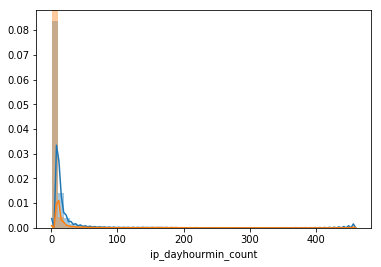

In [120]:
plot_feature(tr[["ip_dayhourmin_count", "is_attributed"]].fillna(0), 'ip_dayhourmin_count')

In [ ]:
#Mid Pulse feature
ip_device_os_dayhour_count = TargetEncoder(cols=['ip_device_os', 'dayofweek', 'hourofday'],  targetcol='is_attributed', func='count')
tr['ip_device_os_dayhour_count'] = ip_device_os_dayhour_count.fit_transform(tr[['ip_device_os', 'dayofweek', 'hourofday', 'is_attributed']])
val['ip_device_os_dayhour_count'] = ip_device_os_dayhour_count.transform(val[['ip_device_os', 'dayofweek', 'hourofday', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'ip_device_oslast_click', 'ip_device_osnext_click',
                  'ip_device_os_std_last_click',
                  'app_count_mean', 'ip_device_os_dayhour_count', 'ip_dayhourmin_count', 'ip_dayhour_count'
                  ]
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
1